# Lab 2 - AD HW
We are implementing image augmentation on the SimpleNN model.


In [1]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.simplefilter("ignore", UserWarning)


In [2]:
USE_COLAB = True

In [3]:
if USE_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
if USE_COLAB:
    %cd /content/drive/MyDrive/DNN Final Project/SemiSupervisedBenchmarking/RotNet

/content/drive/MyDrive/DNN Final Project/SemiSupervisedBenchmarking/RotNet


In [5]:
# Residual Network 20 (ResNet20)
# input is nx3x32x32, output is nx4

# Residual Block
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=inplanes,
            out_channels=planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, out_channels=planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        if inplanes > planes or stride > 1:
            # Option B
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels=inplanes,
                    out_channels=planes,
                    kernel_size=1,
                    stride=stride,
                    padding=0,
                    bias=False,
                ),
                nn.BatchNorm2d(planes),
            )
        else:
            self.downsample = None
        self.stride = stride

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity if self.downsample is None else self.downsample(identity)
        out = F.relu(out)
        return out


# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=4):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv0 = nn.Conv2d(
            in_channels=3,
            out_channels=self.inplanes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn0 = nn.BatchNorm2d(self.inplanes)
        self.layer1 = self._make_layer(block, planes=16, blocks=layers[0], stride=1)
        self.layer2 = self._make_layer(block, planes=32, blocks=layers[1], stride=2)
        self.layer3 = self._make_layer(block, planes=64, blocks=layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_features=64, out_features=num_classes)

    def _make_layer(self, block, planes, blocks, stride):
        layers = []
        for i in range(blocks):
            layers.append(
                block(
                    inplanes=(self.inplanes if i == 0 else planes),
                    planes=planes,
                    stride=stride if i == 0 else 1,
                )
            )
        self.inplanes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn0(self.conv0(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

### Define transformations

In [6]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
# specify preprocessing function
transform_train = transforms.Compose(
    [
        transforms.ToTensor(),  # convert PIL to Tensor
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(size=32, padding=2),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        ),  # normalize the image
    ]
)
transform_val = transforms.Compose(
    [
        transforms.ToTensor(),  # convert PIL to Tensor
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        ),  # normalize the image
    ]
)
#############################################

In [7]:
!pip install torchnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 43.4 MB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29741 sha256=14790abdd83633aa3071009da6a37d77412c7863f6e51a3fa6b4254d70e1f772
  Stored in directory: /root/.cache/pip/wheels/b7/d8/5b/d765b9e8b0c00c0a902ef97f86fe44b9f82ead731c3fb732c9
  Created wheel for visdom: filename=visdom-0.2.3-py3-none-any.whl size=1417107 sha256=2dbb35c1577e81ad09a63194358675e8a8114bda7f41cef93a40415073c7691f
  Stored in directory: /root/.cache/pip/wheels/4d/73/32/0bbe55d2dccb9d80d3f020f474c15a5a1eef232817dcebe776
Successfully built torchnet visdom


### Load data with transformations

In [8]:
from dataloader import DataLoader, GenericDataset

train_set = GenericDataset(
    dataset_name='cifar10',
    split= 'train',
    random_sized_crop=False,)
    # num_imgs_per_cat=num_imgs_per_cat)
val_set = GenericDataset(
    dataset_name='cifar10',
    split='test',
    random_sized_crop=False)

train_loader = DataLoader(
    dataset=train_set,
    batch_size=128,
    unsupervised=True,
    epoch_size=None,
    num_workers=4,
    shuffle=True)

val_loader = DataLoader(
    dataset=val_set,
    batch_size=128,
    unsupervised=True,
    epoch_size=None,
    num_workers=4,
    shuffle=False)

############################################

Files already downloaded and verified
Files already downloaded and verified


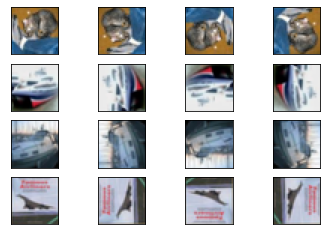

In [9]:
from matplotlib import pyplot as plt
for batch_idx, (inputs, targets) in enumerate(val_loader(0)):
  inv_transform = val_loader.inv_transform
  for i in range(16):
    plt.subplot(4,4,i+1)
    fig=plt.imshow(inv_transform(inputs[i]))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
  plt.show()
  break
  

### Instantiate SimpleNN model and deploy it to GPU devices.

In [10]:
# specify the device for computation
#############################################
# your code here
if torch.cuda.is_available():  # check if NVIDIA GPU is available
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():  # check if Apple's Metal is available
    device = torch.device("mps")
    print(
        f"Checking pytorch is built with mps activated: {torch.backends.mps.is_built()}"
    )
else:
    device = torch.device("cpu")

if device == torch.device("cuda:0") or device == torch.device("mps"):
    print(f"Running on {device} GPU...")
else:
    print("Running on CPU...")

# instantiate the model on device
model = ResNet(BasicBlock, [3, 3, 3]).to(device)

#############################################

Running on cuda:0 GPU...


### Set up the loss function and optimizer

In [11]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 5e-4

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss()

# Add optimizer
optimizer = optim.SGD(
    params=model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG
)
#############################################

### Train model

In [12]:
# some hyperparameters
# total number of training epochs
from http.cookiejar import DefaultCookiePolicy
import pickle  # for saving accuracy and loss

EPOCHS = 100

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model_resnet"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

# BONUS: hyperparams for learning rate scheduler
DECAY_EPOCHS = [30, 60, 80]
DECAY = 0.2

avg_train_acc = []
avg_train_loss = []
avg_val_acc = []
avg_val_loss = []

In [13]:
print("==> Training starts!")
print("=" * 50)


for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    # BONUS
    if i in DECAY_EPOCHS and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)

    #######################
    # your code here
    # switch to train mode
    model.train()

    #######################

    print("Epoch %d:" % i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0  # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader(0)):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)

        # compute the output and loss
        outputs = model(inputs)
        targets = targets.to(device)  # don't forget to also copy targets to device
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        # count the number of correctly predicted samples in the current batch
        _, preds = outputs.max(1)
        total_examples += targets.shape[0]
        correct_examples += preds.eq(targets).sum().item()
        # track loss
        train_loss += loss.item()

        ####################################

    avg_loss = train_loss / len(train_loader(0))
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" % (avg_loss, avg_acc))

    # store train accuracy and loss
    save_train_acc = avg_acc
    avg_train_loss.append(avg_loss)
    avg_train_acc.append(avg_acc)

    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    model.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0  # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader(0)):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)

            # compute the output and loss
            outputs = model(inputs)
            targets = targets.to(device)  # don't forget to also copy targets to device
            loss = criterion(outputs, targets)

            # count the number of correctly preds samples in the current batch
            _, preds = outputs.max(1)
            total_examples += targets.shape[0]
            correct_examples += preds.eq(targets).sum().item()
            # track loss
            val_loss += loss.item()

            ####################################

    avg_loss = val_loss / len(val_loader(0))
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # store val accuracy and loss
    avg_val_loss.append(avg_loss)
    avg_val_acc.append(avg_acc)

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {
            "state_dict": model.state_dict(),
            "epoch": i,
            "lr": current_learning_rate,
            "val_acc": avg_acc,
            "train_acc": save_train_acc,
        }
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, "resnet.pth"))

print("=" * 50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.0598, Training accuracy: 0.5369
Validation loss: 1.2265, Validation accuracy: 0.5391
Saving ...
Epoch 1:
Training loss: 0.8931, Training accuracy: 0.6264
Validation loss: 0.8628, Validation accuracy: 0.6393
Saving ...
Epoch 2:
Training loss: 0.7525, Training accuracy: 0.6929
Validation loss: 0.7704, Validation accuracy: 0.6877
Saving ...
Epoch 3:
Training loss: 0.6572, Training accuracy: 0.7383
Validation loss: 0.8306, Validation accuracy: 0.6883
Saving ...
Epoch 4:
Training loss: 0.5966, Training accuracy: 0.7669
Validation loss: 0.6189, Validation accuracy: 0.7590
Saving ...
Epoch 5:
Training loss: 0.5537, Training accuracy: 0.7845
Validation loss: 0.6320, Validation accuracy: 0.7549
Epoch 6:
Training loss: 0.5189, Training accuracy: 0.7995
Validation loss: 0.5942, Validation accuracy: 0.7733
Saving ...
Epoch 7:
Training loss: 0.4962, Training accuracy: 0.8103
Validation loss: 0.8818, Validation accuracy: 0.6849
Epoch 8:
Training loss: 0

In [ ]:
# # load the best model checkpoint and continue training
# print("==> Loading the best model checkpoint ...")
# checkpoint = torch.load(os.path.join(CHECKPOINT_FOLDER, "resnet.pth"))
# model.load_state_dict(checkpoint["state_dict"])

In [ ]:
# print("==> Training starts again!")
# print("=" * 50)

# EPOCHS = 100


# for i in range(0, EPOCHS):
#     # handle the learning rate scheduler.
#     # BONUS
#     if i in DECAY_EPOCHS and i != 0:
#         current_learning_rate = current_learning_rate * DECAY
#         for param_group in optimizer.param_groups:
#             param_group["lr"] = current_learning_rate
#         print("Current learning rate has decayed to %f" % current_learning_rate)

#     #######################
#     # your code here
#     # switch to train mode
#     model.train()

#     #######################

#     print("Epoch %d:" % i)
#     # this help you compute the training accuracy
#     total_examples = 0
#     correct_examples = 0

#     train_loss = 0  # track training loss if you want

#     # Train the model for 1 epoch.
#     for batch_idx, (inputs, targets) in enumerate(train_loader):
#         ####################################
#         # your code here
#         # copy inputs to device
#         inputs = inputs.to(device)

#         # compute the output and loss
#         outputs = model(inputs)
#         targets = targets.to(device)  # don't forget to also copy targets to device
#         loss = criterion(outputs, targets)

#         # zero the gradient
#         optimizer.zero_grad()

#         # backpropagation
#         loss.backward()

#         # apply gradient and update the weights
#         optimizer.step()

#         # count the number of correctly predicted samples in the current batch
#         _, preds = outputs.max(1)
#         total_examples += targets.shape[0]
#         correct_examples += preds.eq(targets).sum().item()
#         # track loss
#         train_loss += loss.item()

#         ####################################

#     avg_loss = train_loss / len(train_loader)
#     avg_acc = correct_examples / total_examples
#     print("Training loss: %.4f, Training accuracy: %.4f" % (avg_loss, avg_acc))


#     # Validate on the validation dataset
#     #######################
#     # your code here
#     # switch to eval mode
#     model.eval()

#     #######################

#     # this help you compute the validation accuracy
#     total_examples = 0
#     correct_examples = 0

#     val_loss = 0  # again, track the validation loss if you want

#     # disable gradient during validation, which can save GPU memory
#     with torch.no_grad():
#         for batch_idx, (inputs, targets) in enumerate(val_loader):
#             ####################################
#             # your code here
#             # copy inputs to device
#             inputs = inputs.to(device)

#             # compute the output and loss
#             outputs = model(inputs)
#             targets = targets.to(device)  # don't forget to also copy targets to device
#             loss = criterion(outputs, targets)

#             # count the number of correctly preds samples in the current batch
#             _, preds = outputs.max(1)
#             total_examples += targets.shape[0]
#             correct_examples += preds.eq(targets).sum().item()
#             # track loss
#             val_loss += loss.item()

#             ####################################

#     avg_loss = val_loss / len(val_loader)
#     avg_acc = correct_examples / total_examples
#     print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

#     # save the model checkpoint
#     if avg_acc > best_val_acc:
#         best_val_acc = avg_acc
#         if not os.path.exists(f"{CHECKPOINT_FOLDER}_cont"):
#             os.makedirs(f"{CHECKPOINT_FOLDER}_cont")
#         print("Saving ...")
#         state = {
#             "state_dict": model.state_dict(),
#             "epoch": i,
#             "lr": current_learning_rate,
#             "loss": avg_loss,
#             "acc": avg_acc,
#         }
#         torch.save(state, os.path.join(f"{CHECKPOINT_FOLDER}_cont", "resnet.pth"))

In [ ]:
# save/load the training and validation accuracy and loss
SAVE_NEW_DATA = True
if SAVE_NEW_DATA:
    with open(os.path.join(CHECKPOINT_FOLDER, "train_acc.pkl"), "wb") as f:
        pickle.dump(avg_train_acc, f)
    with open(os.path.join(CHECKPOINT_FOLDER, "train_loss.pkl"), "wb") as f:
        pickle.dump(avg_train_loss, f)
    with open(os.path.join(CHECKPOINT_FOLDER, "val_acc.pkl"), "wb") as f:
        pickle.dump(avg_val_acc, f)
    with open(os.path.join(CHECKPOINT_FOLDER, "val_loss.pkl"), "wb") as f:
        pickle.dump(avg_val_loss, f)
else:
    with open(os.path.join(CHECKPOINT_FOLDER, "train_acc.pkl"), "rb") as f:
        avg_train_acc = pickle.load(f)
    with open(os.path.join(CHECKPOINT_FOLDER, "train_loss.pkl"), "rb") as f:
        avg_train_loss = pickle.load(f)
    with open(os.path.join(CHECKPOINT_FOLDER, "val_acc.pkl"), "rb") as f:
        avg_val_acc = pickle.load(f)
    with open(os.path.join(CHECKPOINT_FOLDER, "val_loss.pkl"), "rb") as f:
        avg_val_loss = pickle.load(f)

### Save predictions

In [ ]:
DATA_ROOT = "./data"
BATCH_SIZE = 100

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

test_set = CIFAR10(root=DATA_ROOT, mode="test", download=True, transform=transform_test)

# do NOT shuffle your test data loader!!!!!!!!!!!!!!!!
# otherwise the order of samples will be messed up
# and your test accuracy is likely to drop to random guessing level
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

#########################################################
# use your model to generate predictions on test data
# and save the results into variable "results"
# "results" should be either a numpy array or a torch tensor with length of 10000

# initialize a resnet and load trained weights
net = ResNet(BasicBlock, [3, 3, 3])
state_dict = torch.load(
    os.path.join(CHECKPOINT_FOLDER, "resnet.pth")
)  # change the path to your own checkpoint file
net.load_state_dict(state_dict["state_dict"])
net.to(device)

# remember to switch to eval mode whenever you are making inference
net.eval()

results = []
with torch.no_grad():
    for x in test_loader:
        results.append(net(x.to(device)).argmax(1))

# convert results to numpy array
results = torch.cat(results).cpu().numpy()
assert len(results) == 10000

#########################################################
with open(os.path.join(CHECKPOINT_FOLDER, "predictions.csv"), "w") as fp:
    fp.write("Id,Label\n")
    for i in range(len(results)):
        fp.write("%d,%d\n" % (i, results[i]))

Using downloaded and verified file: ./data/cifar10_test_F22.zip
Extracting ./data/cifar10_test_F22.zip to ./data
Files already downloaded and verified
